In [60]:
import os
import music21 as m21
import json
import keras
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # cuz my version of python complains about deprecated stuff

In [3]:
songs_path = "songs"
acceptable_durations = [0.25, 0.5, 0.75, 1.0, 1.5, 2, 3, 4]
preprocessing_path = "preprocessing"
single_file_path = "input"
mapping_path = "mapping.json"
sequence_length = 64

### Preprocessing

Using the "Generating Melodies with a Neural Network" series by Valerio Velardo on youtube, I took inspiration for preprocessing. He uses a German folksong dataset, and I used the Kaggle Lofi dataset.
I tried:
- filtering out songs with notes with weird durations (so it doesn't do insanely short or insanely long notes)
- transposing all training data to C major or A minor (cuz all songs are in some major/minor key signature, but I figured this would kinda standardize the data so that anything produced would remain in the appropriate key and not sound so off-putting)
- translating all the midi files to their own .txts encoded into the music notes as characters
- squishing all those together to make the input data

In [4]:
def load_songs(folder_path):
    songs = []

    for file in os.listdir(folder_path):
        song = m21.converter.parse(os.path.join(folder_path, file))
        songs.append(song)

    return songs

def has_acceptable_notes(song, acceptable_durations):
    for note in song.flatten().notesAndRests: # filters out metadata from the m21 stuff so it's just the notes
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True
        
def transpose(song):
    key = song.analyze('key')

    if key.mode == 'major':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    elif key.mode == 'minor':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('A'))

    transposed_song = song.transpose(interval)
    return transposed_song

def encode_song(song, time_step = 0.25):
    encoded_song = []

    for note in song.flatten().notesAndRests:
        if isinstance(note, m21.note.Note):
            symbol = note.pitch.nameWithOctave
        elif isinstance(note, m21.note.Rest):
            symbol = "r"
        elif isinstance(note, m21.chord.Chord):
            symbol = note.root().nameWithOctave
        
        steps = int(note.duration.quarterLength / time_step)

        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song

def load(path):
    with open(path, "r") as f:
        song = f.read()
    return song

def condense(dataset_path, file_dataset_path):
    delimiter = "/ " # to signify the end of a song
    songs = ""

    for file in os.listdir(dataset_path):
        path = os.path.join(dataset_path, file)
        song = load(path)
        songs += song + " " + delimiter
    songs = songs[:-1] # gets rid of the final delimiter

    with open(file_dataset_path, "w") as f:
        f.write(songs)

    return songs


def preprocess(folder_path):
    print("Loading songs...")
    songs = load_songs(folder_path)
    print(f"Loaded {len(songs)} songs.\n")
    
    for i, song in enumerate(songs):
        if not has_acceptable_notes(song, acceptable_durations):
            continue

        transposed_song = transpose(song)

        encoded_song = encode_song(transposed_song)

        save_path = os.path.join(preprocessing_path, str(i))
        with open(save_path + ".txt", "w") as f:
            f.write(encoded_song)

In [5]:
preprocess(songs_path)
songs = condense(preprocessing_path, single_file_path)

Loading songs...
Loaded 93 songs.



Mapping to Readable Notation

In [6]:
def create_mapping(songs, mapping_path):
    mappings = {}

    songs = songs.split()
    vocab = sorted(set(songs)) # keeps unique symbols in order

    for i, symbol in enumerate(vocab): # isolates unique symbols
        mappings[symbol] = i

    with open(mapping_path, "w") as f:
        json.dump(mappings, f, indent=4)

def convert_to_int(songs):
    int_songs = []

    with open(mapping_path, "r") as f:
        mappings = json.load(f)
    songs = songs.split()

    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

def generate_batches(sequence_length):
    songs = load(single_file_path)
    int_songs = convert_to_int(songs)

    inputs = []
    targets = []

    for i in range(len(int_songs) - sequence_length):
        inputs.append(int_songs[i:i + sequence_length])
        targets.append(int_songs[i + sequence_length])

    vocab_size = len(set(int_songs))
    inputs = keras.utils.to_categorical(inputs, num_classes=vocab_size)
    targets = np.array(targets)

    return inputs, targets

In [7]:
create_mapping(songs, mapping_path)
inputs, targets = generate_batches(sequence_length=64)

### Model 1, using LSTM cells + one hot encoding

In [38]:
vocab_size = 41
model1 = keras.Sequential()
model1.add(keras.Input(shape=(None, vocab_size)))
model1.add(keras.layers.LSTM(128))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(vocab_size, activation='softmax'))

early_stop = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
learning_rate = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 5)

model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])
model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 128)            │        87,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,329 (360.66 KB)

 Trainable params: 92,329 (360.66 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model1.fit(inputs, targets, epochs=60, batch_size=64, validation_split=0.2, callbacks=[early_stop, learning_rate])
model1.save("model1.keras")

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6922 - loss: 2.0364 - val_accuracy: 0.5694 - val_loss: 2.2405 - learning_rate: 0.0010
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 1.3308 - val_accuracy: 0.5694 - val_loss: 2.0590 - learning_rate: 0.0010
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 1.3142 - val_accuracy: 0.5694 - val_loss: 2.0824 - learning_rate: 0.0010
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 1.2890 - val_accuracy: 0.5694 - val_loss: 2.1143 - learning_rate: 0.0010
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 1.2962 - val_accuracy: 0.5694 - val_loss: 2.0124 - learning_rate: 0.0010
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 1.2892 - val_accuracy: 0.5694 - val_loss: 2.0033 - learning_rate: 0.0010
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7514 - loss: 1.2786 - val_acc

In [41]:
generator = keras.models.load_model("model1.keras")
mappings = json.load(open(mapping_path, "r"))

In [42]:
def generate(model, mappings, sequence_length, seed, num_steps=500, temperature=1.0):
    reverse_mapping = {v: k for k, v in mappings.items()}
    vocab_size = len(mappings)

    seed_int = [mappings[symbol] for symbol in seed.split()]
    output = list(seed_int)

    for _ in range(num_steps):
        seed_sequence = output[-sequence_length:]
        onehot = keras.utils.to_categorical(seed_sequence, num_classes=vocab_size)
        onehot = np.expand_dims(onehot, axis=0)

        preds = model.predict(onehot, verbose=0)[0]

        preds = np.log(preds + 1e-8) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))

        next_idx = np.random.choice(range(vocab_size), p=preds)
        output.append(next_idx)

    generated = [reverse_mapping[i] for i in output]
    return " ".join(generated)

def decode_song(encoded_song, time_step=0.25, file_name="generated_song"):
    song_stream = m21.stream.Stream()
    symbols = encoded_song.split()
    step_counter = 0
    prev_symbol = None

    for symbol in symbols:
        if symbol != "_":
            if prev_symbol and step_counter > 0:
                dur = m21.duration.Duration(step_counter * time_step)
                song_stream[-1].duration = dur
            
            if symbol == "r" or symbol == "/":
                song_stream.append(m21.note.Rest())
            elif "." in symbol:
                pitches = [int(x) for x in symbol.split(".")]
                song_stream.append(m21.chord.Chord(pitches))
            else:
                pitch = m21.pitch.Pitch(symbol)
                song_stream.append(m21.note.Note(pitch))
            
            step_counter = 1
            prev_symbol = symbol
        else:
            step_counter += 1

    song_stream.write("midi", fp=f"{file_name}.mid")
    return song_stream

In [43]:
seed = "A4 _ _ _ _ _ F4 _ _ _ _ _ C5 _ _ _ _ _ _ G4 _ _ _ _" # so each has the same starting notes
generated = generate(model1, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=0.8)
model1_low = decode_song(generated, time_step=0.25, file_name="model1_low_temp")

In [44]:
generated = generate(model1, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=2)
model1_high = decode_song(generated, time_step=0.25, file_name="model1_high_temp")

### Model 2, using LSTM + trainable embeddings
This needs modifying the batches to take the one hot encoding out

In [45]:
def generate_batches(sequence_length):
    songs = load(single_file_path)
    int_songs = convert_to_int(songs)

    inputs = []
    targets = []
    
    for i in range(len(int_songs) - sequence_length):
        inputs.append(int_songs[i:i + sequence_length])
        targets.append(int_songs[i + sequence_length])

    vocab_size = len(set(int_songs))

    inputs = np.array(inputs) 
    targets = np.array(targets)

    return inputs, targets, vocab_size

inputs, targets, vocab_size = generate_batches(sequence_length=64)

In [52]:
embedding_dim = 64

model2 = keras.Sequential()
model2.add(keras.Input(shape=(sequence_length,)))
model2.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model2.add(keras.layers.LSTM(128))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(vocab_size, activation='softmax'))

model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])
model2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 64, 64)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,729 (416.91 KB)

 Trainable params: 106,729 (416.91 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model2.fit(inputs, targets, epochs=60, batch_size=64, validation_split=0.2, callbacks=[early_stop, learning_rate])
model2.save("model2.keras")
generator = keras.models.load_model("model2.keras")

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7194 - loss: 1.9814 - val_accuracy: 0.5694 - val_loss: 2.0297 - learning_rate: 0.0010
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7514 - loss: 1.3214 - val_accuracy: 0.5694 - val_loss: 2.0043 - learning_rate: 0.0010
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7514 - loss: 1.2885 - val_accuracy: 0.5694 - val_loss: 1.9102 - learning_rate: 0.0010
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7514 - loss: 1.2562 - val_accuracy: 0.5667 - val_loss: 1.8665 - learning_rate: 0.0010
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7542 - loss: 1.2122 - val_accuracy: 0.5639 - val_loss: 1.8300 - learning_rate: 0.0010
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7549 - loss: 1.1755 - val_accuracy: 0.5583 - val_loss: 1.8407 - learning_rate: 5.0000e-04
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7625 - loss: 1.1568 - val

In [54]:
def generate_with_embeddings(model, mappings, sequence_length, seed, num_steps=500, temperature=1.0):
    reverse_mapping = {v: k for k, v in mappings.items()}
    vocab_size = len(mappings)

    seed_int = [mappings[symbol] for symbol in seed.split()]
    output = list(seed_int)

    for _ in range(num_steps):
        seed_sequence = output[-sequence_length:] # now one-hot encoding is not needed
        seed_sequence = np.array([seed_sequence])

        preds = model.predict(seed_sequence, verbose=0)[0]

        preds = np.log(preds + 1e-8) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))

        next_idx = np.random.choice(range(vocab_size), p=preds)
        output.append(next_idx)

    generated = [reverse_mapping[i] for i in output]
    return " ".join(generated)

In [55]:
generated = generate_with_embeddings(model2, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=0.8)
model2_low = decode_song(generated, time_step=0.25, file_name="model2_low_temp")

In [56]:
generated = generate_with_embeddings(model2, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=2)
model2_high = decode_song(generated, time_step=0.25, file_name="model2_high_temp")

### Observations


- really low temp (<0.5ish) for model 1 cuts off just about right after the seed is done. I think this is cuz the training data typically only contains snippets that are a few chords long, so it predicts the delimiter which cuts off the song
- model 2 however with low temp is a lot better about keeping stuff in the proper key signature? it kinda sounds like boss music to me. not as many rests though
- low temp for trainable embeddings has lots of sustained notes
- tried GRU for model 2 with trainable embeddings, but it produced so many rests that I ended up switching back to LSTM
- high temp for both models consistently chooses less rests in a row
- pauses every once in a while, likely due to the pause between songs in the input

### Diagrams

##### Model 2, high temp display

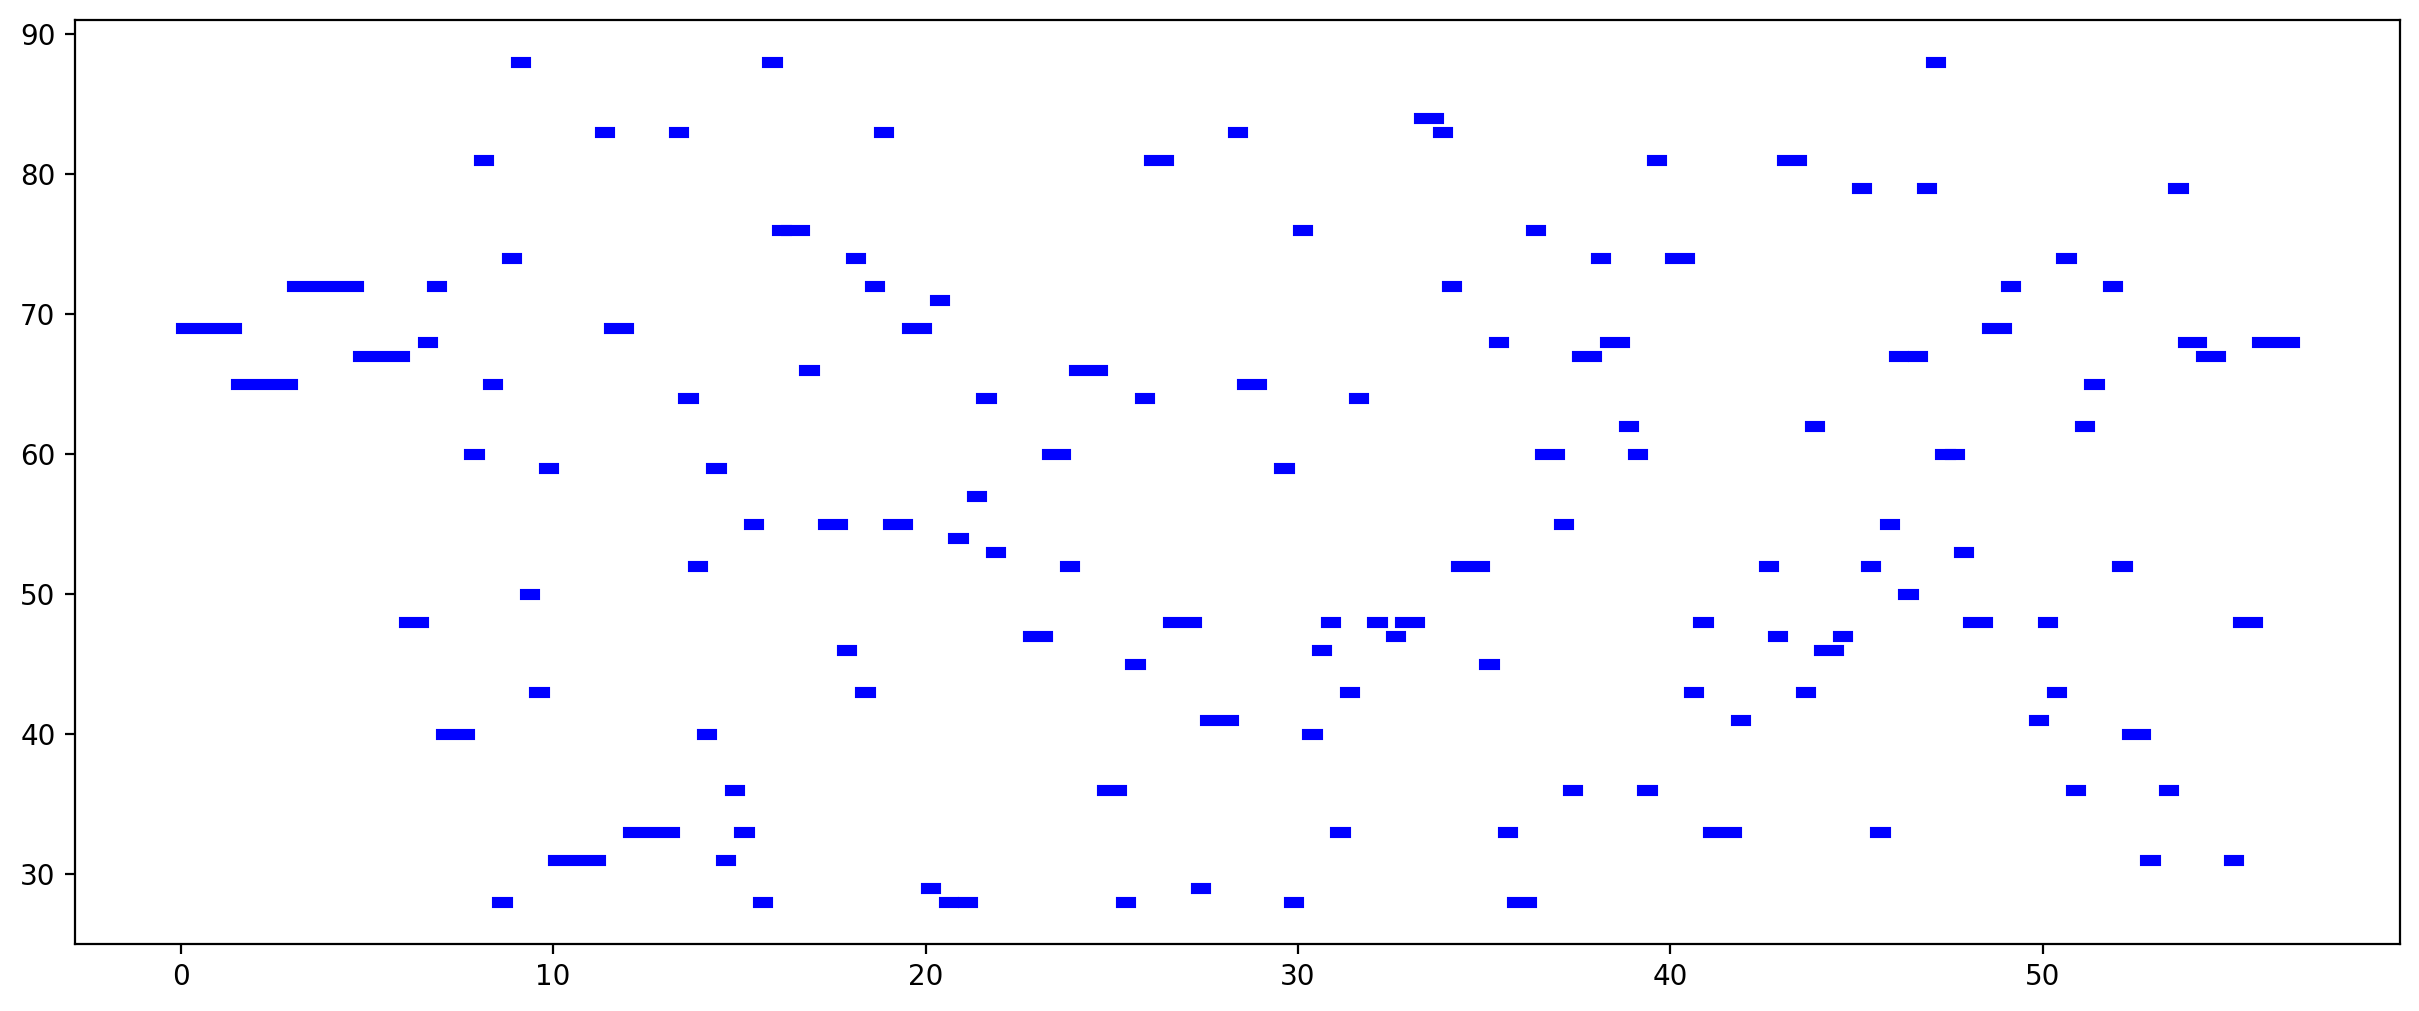

In [57]:
def visualize_midi(song_stream):
    plt.figure(figsize=(15, 6))
    
    for element in song_stream.flatten().notesAndRests:
        if isinstance(element, m21.note.Note): # does not plot rests
            plt.plot([element.offset, element.offset + element.duration.quarterLength], 
                    [element.pitch.midi, element.pitch.midi], 'b-', linewidth=4)
    plt.show()

visualize_midi(model2_high)

##### Model 2 high temp note usage count

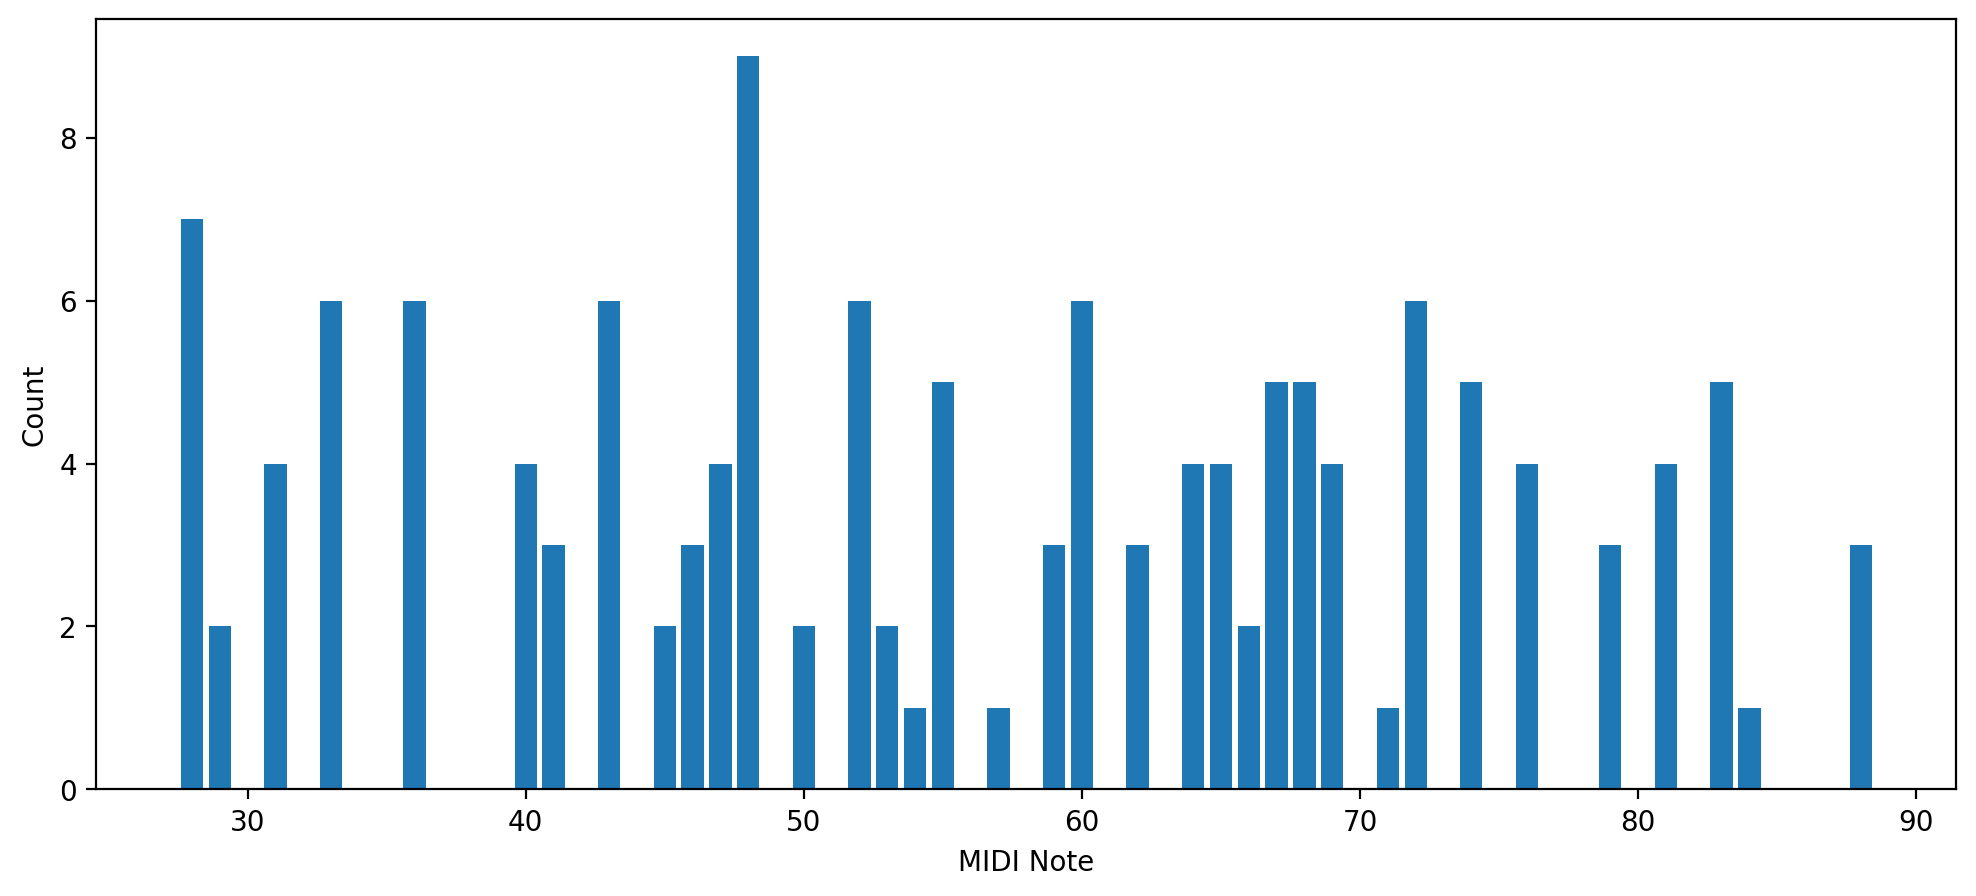

In [58]:
from collections import Counter

def plot_note_frequency(song_stream):
    notes = []
    for element in song_stream.flatten().notesAndRests:
        if isinstance(element, m21.note.Note):
            notes.append(element.pitch.midi)
        elif isinstance(element, m21.chord.Chord):
            notes.extend([p.midi for p in element.pitches])
    
    counts = Counter(notes)
    
    plt.figure(figsize=(12, 5))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('MIDI Note')
    plt.ylabel('Count')
    plt.show()

plot_note_frequency(model2_high)

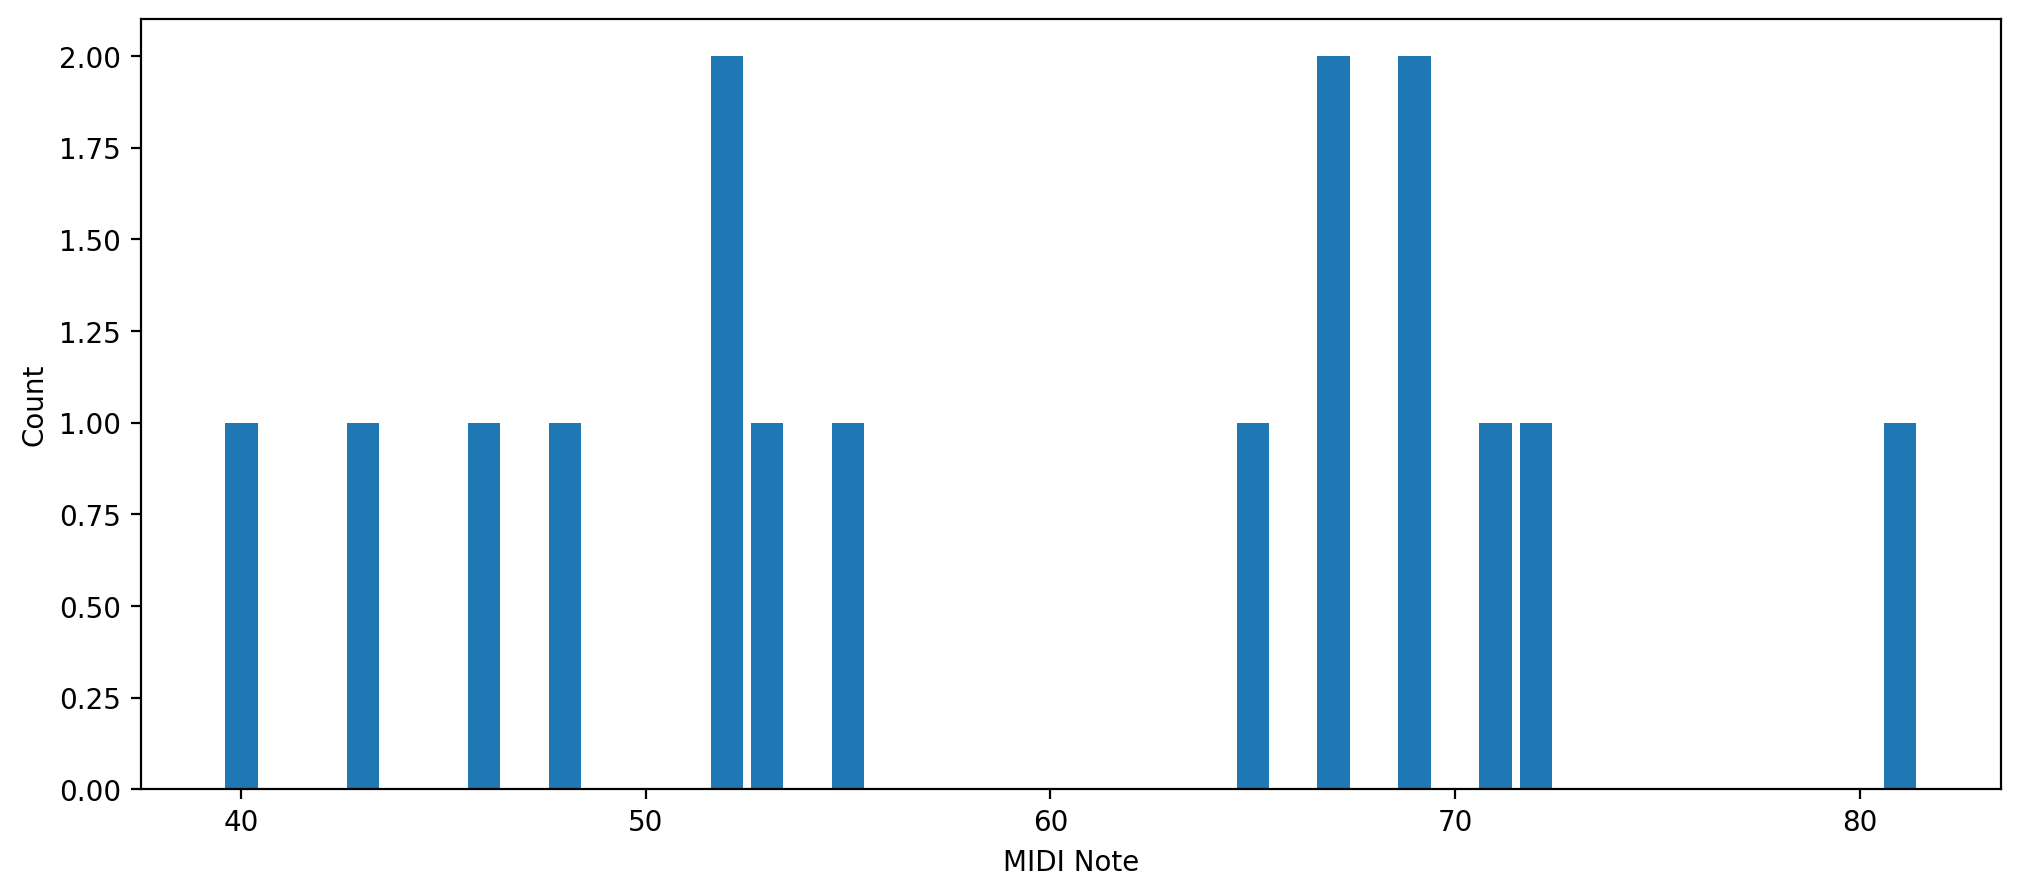

In [59]:
plot_note_frequency(model2_low)

for reference, midi note chart by Matthijs Hollemans:
<br/>
<img src="midi-note-chart.jpg" width="500">